<a href="https://colab.research.google.com/github/zhus-dika/railways_caclulations/blob/main/railways_calculations_volume_data_p1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐸 Getting data from stat.gov

## 🦉 Download spreadsheets & make dataframes

### 🦤 Install need packages

In [1]:
! pip install pyexcel pyexcel-xls pyexcel-xlsx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 5.5 MB/s eta 0:00:00


### 🪲 Imports

In [2]:
import glob
from os import listdir
import os
from os.path import isfile, join
import pyexcel as p

from openpyxl import load_workbook

import pandas as pd

import subprocess

### 🐤 Useful methods

In [3]:
def convert2xlsx():

  files_xlsx = glob.glob("*.xls*")
  files_xls = glob.glob("*.xls")
  files_xlsx.sort(key=os.path.getmtime)
  if len(files_xls) > 0:
    for idx, i in enumerate(files_xls):
        p.save_book_as(file_name=i,
                      dest_file_name=i.replace('.xls', '.xlsx'))
        os.remove(i)
        files_xlsx[idx] = files_xlsx[idx].replace('.xls', '.xlsx')
  return files_xlsx

In [4]:
def prepare_files_rar():
  # get all files to make correct ordering
  files = glob.glob("*")
  files.sort(key=os.path.getmtime)

  file2int = {}

  for idx, file in enumerate(files):
    file2int[file.split('.')[0]] = idx

  # unrar .rar files and remove them
  files_rar = glob.glob("*.rar")

  for file_rar in files_rar:
    correct = subprocess.run(['unrar', '-y', 'x', file_rar], check=True, text=True)
    correct = subprocess.run(['rm', '-r', file_rar], check=True, text=True)

  # move inner files with extensions .xls & .xlsx
  for path in files_rar:
    files = os.listdir(path=path[:-4])
    files_xls = glob.glob(f"{path[:-4]}/*.xls")

    if len(files_xls) > 1:
      for file_xls in files_xls:
        if os.path.join(path[:-4], "3. Производство промышленной продукции в натуральном выражении.xls") != file_xls:
          correct = subprocess.run(['rm', '-r', file_xls], check=True, text=True)

    files_xls = glob.glob(f"{path[:-4]}/*.xls")
    for selected_file in files_xls:
      os.rename(selected_file, f"{path[:-4]}.xls")
    files_xlsx = glob.glob(f"{path[:-4]}/*.xlsx")
    for selected_file in files_xlsx:
      os.rename(selected_file, f"{path[:-4]}.xlsx")


  files_xlsx = glob.glob("*.xls*")
  files_xls = glob.glob("*.xls")

  files_xlsx = convert2xlsx()

  files_xlsx_upd = [i for i in files_xlsx]

  for file_xlsx in files_xlsx:
    files_xlsx_upd[file2int[file_xlsx.split('.')[0]]] = file_xlsx

  return files_xlsx_upd

In [5]:
def generate_table_data(files_xlsx):

  table_data = []
  for i in files_xlsx:
    wb = load_workbook(i)
    main_sheets = ["3 табл", "3", "3 ", " 3", "Лист1", "бюллетень 2 мес", "бюллетень 4 мес", "бюллетень 6 мес", "бюллетень 8 мес", "бюллетень 10 мес", "бюллетень 12 мес", "Данные"]
    for main_sheet in main_sheets:
      if main_sheet in wb.sheetnames:
        table_data.append(wb[main_sheet])
        break
  return table_data

In [6]:
def fill_volumes(table_data, year, name_column='J'):

  commodities_names = []

  table_rows = []
  for table_num in range(len(table_data)):
    commodities_names_2 = []
    rows = {}
    for i in range(8, 354):
      if table_data[table_num]['I'+str(i)].value != None and table_data[table_num][name_column + str(i)].value != None:
        value = table_data[table_num][name_column+str(i)].value
        value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').replace("\n", " ").lower()
        name = " ".join(value.split())
        if 'гранулы крошка каменная и порошок каменный; галька гравий щебень или камень дробленый тыс куб м' == name:
          name = 'гранулы крошка каменная и порошок каменный; галька гравий щебень или камень дробленный тыс куб м'
        if 'золото необработанное и полуобработанное или в виде порошка кг' == name:
          name = 'золото необработанное и полу обработанное или в виде порошка кг'
        commodities_names_2.append(name)
        rows[name] = i
    table_rows.append(rows)
    commodities_names.append(commodities_names_2)
  commodities_volumes = {str(i) + '_' + str(year): [] for i in range(1, 13)}
  commodities_volumes['name'] = []
  common_names = set(commodities_names[0])
  for i in range(1, 6):
    common_names = common_names & set(commodities_names[i])

  for name in common_names:

    commodities_volumes['name'].append(name)

    for table_num in range(len(table_data)):

      i = table_rows[table_num][name]
      val_volume_1 = table_data[table_num]['B'+str(i)].value
      commodities_volumes[str(2 * table_num + 1) + '_' + str(year)].append(val_volume_1)
      val_volume_2 = table_data[table_num]['C'+str(i)].value
      commodities_volumes[str(2 * table_num + 2)  + '_' + str(year)].append(val_volume_2)
  return commodities_volumes

### 🦜 2018 year per month

In [7]:
! rm -r *

In [8]:
# ! wget https://stat.gov.kz/api/iblock/element/49161/file/ru/

In [9]:
! wget 'https://stat.gov.kz/upload/iblock/902/aobfv3djds58bmyhkqaktyjpzb2iuybc/2_2018_%D0%91-04-01-%D0%9C.rar' #1-2
! wget 'https://stat.gov.kz/upload/iblock/fb0/9j1tlw2sf4gcrm0q9vjhrl6o9t9rc7v8/4_2018_%D0%91-04-01-%D0%9C.rar' #1-4
! wget 'https://stat.gov.kz/upload/iblock/919/dwds1m0pf83dbdpucwfa0e16o162wm4f/6_2018_%D0%91-04-01-%D0%9C.rar' #1-6
! wget 'https://stat.gov.kz/upload/iblock/7b5/qf2p59p7wnjpbgy23say98ls1ruzf3x5/8_2018_%D0%91-04-01-%D0%9C.rar' #1-8
! wget 'https://stat.gov.kz/upload/iblock/ef8/kj8ilh6pam18b1m5bkfgx8pcf4h7iav9/10_2018_%D0%91-04-01-%D0%9C.rar' #1-10
! wget 'https://stat.gov.kz/upload/iblock/890/bw4d5zwmn1i1rosuz2ifvfa4qgw7haa1/12_2018_%D0%91-04-01-%D0%9C.rar' #1-12

--2025-02-12 05:25:24--  https://stat.gov.kz/upload/iblock/902/aobfv3djds58bmyhkqaktyjpzb2iuybc/2_2018_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154352 (151K) [application/x-rar-compressed]
Saving to: ‘2_2018_Б-04-01-М.rar’

2_2018_Б-04-01-М.ra 100%[===================>] 150.73K   329KB/s    in 0.5s    

2025-02-12 05:25:25 (329 KB/s) - ‘2_2018_Б-04-01-М.rar’ saved [154352/154352]

--2025-02-12 05:25:25--  https://stat.gov.kz/upload/iblock/fb0/9j1tlw2sf4gcrm0q9vjhrl6o9t9rc7v8/4_2018_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154410 (151K) [application/x-rar-compressed]
Saving to: ‘4_2018_Б-04-01-М.rar’

4_2018_Б-04-01-М.ra 100%[===================>] 150.79K   330

In [10]:
files_xlsx = prepare_files_rar()

In [11]:
df_2018 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2018))
df_2018

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,11_2018,12_2018,name
0,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,14220.0,21893,рис полуобрушенный или полностью обрушенный ил...
1,31.4,73.7,74.9,41.2,37.3,410.4,410.4,440.3,440.3,440.3,461.4,461.4,окна и их рамы двери застекленные и их рамы дв...
2,39.5,47.5,62.4,57.7,56.6,52.5,54.2,53,47.4,40.3,44.3,43.4,концентраты цинковые тыс тонн
3,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,102.0,102,кумыс тонн
4,803.0,1029.0,1284.0,1160.0,1363.0,2011.0,1534.0,1548,1615.0,1526,1663.0,1750,масло сливочное и спреды пасты молочные тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,9445.5,9729.4,9733.7,8598.6,7782.2,7674.1,8080.7,9759.2,10464.8,10393.7,10783.4,11258.1,уголь каменный включая лигнит кроме концентрат...
246,1141.0,1057.4,1142.9,1121.5,1039.1,1127.1,1115.6,1102.1,872.4,965.8,1065.5,1112.8,конденсат газовый тыс тонн
247,473.7,451.3,464.5,481.0,511.6,480.5,476.8,416.2,390.8,443.7,203.8,126,агломерат железорудный тыс тонн
248,561.0,970.0,621.0,693.0,465.0,643.0,786.0,698,1110.0,887,1099.0,1588,аппаратура для отключения переключения или защ...


### 🐨 2019 year per month

In [12]:
! rm -r *

In [13]:
# ! wget https://stat.gov.kz/api/iblock/element/49133/file/ru/

In [14]:
! wget 'https://stat.gov.kz/upload/iblock/3d0/spwao8pmj590p21oj6jjmrsa84gcaeup/02_2019_%D0%91-04-01-%D0%9C.rar' #1-2
! wget 'https://stat.gov.kz/upload/iblock/577/f20py2ccajbmf5o4kacuiv355iz42wv6/04_2019_%D0%91-04-01-%D0%9C.xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/fe4/z6wj3wuac71s3u7xc6pv26ozo0yba8sp/06_2019_%D0%91-04-01-%D0%9C.xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/0e7/jlalo81y1p4tdoi01u3yojfccv7q99h2/08_2019_%D0%91-04-01-%D0%9C.xls' #1-8
! wget 'https://stat.gov.kz/upload/iblock/d29/79ljbm8q3ibp0svmm6y4us55f3ql6xlo/10_2019_%D0%91-04-01-%D0%9C.xls' #1-10
! wget 'https://stat.gov.kz/upload/iblock/505/b3iaejrhcby1o5qf3wu5tlarbeqwhu7c/12_2019_%D0%91-04-01-%D0%9C.xls' #1-12

--2025-02-12 05:25:37--  https://stat.gov.kz/upload/iblock/3d0/spwao8pmj590p21oj6jjmrsa84gcaeup/02_2019_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154632 (151K) [application/x-rar-compressed]
Saving to: ‘02_2019_Б-04-01-М.rar’

02_2019_Б-04-01-М.r 100%[===================>] 151.01K   164KB/s    in 0.9s    

2025-02-12 05:25:39 (164 KB/s) - ‘02_2019_Б-04-01-М.rar’ saved [154632/154632]

--2025-02-12 05:25:39--  https://stat.gov.kz/upload/iblock/577/f20py2ccajbmf5o4kacuiv355iz42wv6/04_2019_%D0%91-04-01-%D0%9C.xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276480 (270K) [application/vnd.ms-excel]
Saving to: ‘04_2019_Б-04-01-М.xls’

04_2019_Б-04-01-М.x 100%[===================>] 270.00K   17

In [15]:
files_xlsx = prepare_files_rar()

In [16]:
df_2019 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2019))
df_2019

,1_2019,2_2019,3_2019,4_2019,5_2019,6_2019,7_2019,8_2019,9_2019,10_2019,11_2019,12_2019,name
0,9377.0,16073,14164,14191,10211.0,10198.0,9327.0,8115.0,8094.0,8105.0,12121.0,24247.0,рис полуобрушенный или полностью обрушенный ил...
1,410.4,453.8,453.8,453.8,420.3,420.3,420.3,424.8,424.8,424.8,433.2,433.2,окна и их рамы двери застекленные и их рамы дв...
2,5478018.0,6318660,5645999,7960740,7311089.0,5837810.0,6973488.0,3810749.0,7213814.0,9453682.0,9960013.0,5256328.0,лекарства тыс тенге
3,37.6,42.4,51.3,46.2,60.6,66.7,50.7,74.9,79.6,89.5,78.3,74.6,концентраты цинковые тыс тонн
4,51.0,116,116,116,63.0,63.0,63.0,97.0,97.0,97.0,112.0,112.0,кумыс тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,9851.7,9505.8,9381.9,8167.4,6967.9,8017.0,8074.4,9132.2,9887.9,10085.6,10948.4,11063.0,уголь каменный включая лигнит кроме концентрат...
233,1081.8,1008.9,1093.5,1024.7,1054.5,1018.5,1066.3,1074.3,510.6,731.0,1112.3,1135.3,конденсат газовый тыс тонн
234,304.4,322.9,451.5,506.8,530.7,491.5,534.5,510.5,406.9,428.9,528.2,534.4,агломерат железорудный тыс тонн
235,675.0,1025,580,887,495.0,679.0,802.0,1415.0,678.0,877.0,950.0,1276.0,аппаратура для отключения переключения или защ...


In [17]:
df = df_2018.set_index('name').join(df_2019.set_index('name'), on='name')

### 🐻 2020 year per month

In [18]:
! rm -r *

In [19]:
# ! wget https://stat.gov.kz/api/iblock/element/49113/file/ru/

In [20]:
! wget 'https://stat.gov.kz/upload/iblock/a8a/h7odaow8re9jy36o2defzgd8lloud61b/02_2020_%D0%91-04-01-%D0%9C.xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/6a6/o9fy7vi1unm3f6qyyblpbbr0biyx7ubo/%D0%91-04-01-%D0%9C%20(4%202020).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/29d/t128ej0f1edw811ho2491cat3x3fgm1e/%D0%91-04-01-%D0%9C%20(6%202020).xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/a77/xum5h2ea3anc1gy960xz0z4fibfc2qxn/%D0%91-04-01-%D0%9C(8%202020).rar' #1-8
! wget 'https://stat.gov.kz/upload/iblock/b86/h9a0m5kw5wqvk9yt0d9e4ko5ozd862es/%D0%91-04-01-%D0%9C(10%202020).rar' #1-10
! wget 'https://stat.gov.kz/upload/iblock/d67/t8bp3s2mobqxlbp7aobn0m0di43etmmz/%D0%91-04-01-%D0%9C%20(12%202020).rar' #1-12

--2025-02-12 05:25:52--  https://stat.gov.kz/upload/iblock/a8a/h7odaow8re9jy36o2defzgd8lloud61b/02_2020_%D0%91-04-01-%D0%9C.xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287232 (280K) [application/vnd.ms-excel]
Saving to: ‘02_2020_Б-04-01-М.xls’

02_2020_Б-04-01-М.x 100%[===================>] 280.50K   179KB/s    in 1.6s    

2025-02-12 05:25:54 (179 KB/s) - ‘02_2020_Б-04-01-М.xls’ saved [287232/287232]

--2025-02-12 05:25:54--  https://stat.gov.kz/upload/iblock/6a6/o9fy7vi1unm3f6qyyblpbbr0biyx7ubo/%D0%91-04-01-%D0%9C%20(4%202020).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312320 (305K) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (4 2020).xls’

Б-04-01-М (4 2020). 100%[===================>] 305.00K   

In [21]:
files_xlsx = prepare_files_rar()

df_2020 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2020))

In [22]:
df_2020

,1_2020,2_2020,3_2020,4_2020,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020,name
0,9337,22381,22399,22270,16750,15392,14764,13763,13739,13758,12716,23041,рис полуобрушенный или полностью обрушенный ил...
1,420.3,467.9,467.9,467.9,48.6,48.6,48.6,243.8,243.8,243.8,43.7,43.7,окна и их рамы двери застекленные и их рамы дв...
2,7365974,10221482,10945627,9410691,7315481,9822288,7932708,10438885,11128354,15481288,14671767,12425977,лекарства тыс тенге
3,59.4,72.1,81.1,45.1,57.4,52.4,55,40.5,51.9,50.2,48.8,46.7,концентраты цинковые тыс тонн
4,63,79,79,79,82,82,82,132,132,132,131,131,кумыс тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,10671,8569.2,9138.2,8754.2,7821.2,6891.6,7161,7999.4,13582.9,10050.8,15320.1,15944.9,руды медные тыс тонн
272,9670.6,8979.1,9480.3,8873.6,7948.3,7709.3,8029.3,8346.2,8812.5,9991.7,10293.3,11093.4,уголь каменный включая лигнит кроме концентрат...
273,1139.6,1055.3,1098.8,1050.7,1085.8,1070,1043.8,1066.7,821.6,974.9,1114.1,1128.1,конденсат газовый тыс тонн
274,-,17,4,1,14,76,112,148,108,68,114,79,комбайны зерноуборочные штук


In [23]:
df = df.join(df_2020.set_index('name'), on='name')

In [24]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2020,4_2020,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020
name,,,,,,,,,,,,,,,,,,,,,
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,22399,22270,16750,15392,14764,13763,13739,13758,12716,23041
окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м,31.4,73.7,74.9,41.2,37.3,410.4,410.4,440.3,440.3,440.3,...,467.9,467.9,48.6,48.6,48.6,243.8,243.8,243.8,43.7,43.7
концентраты цинковые тыс тонн,39.5,47.5,62.4,57.7,56.6,52.5,54.2,53,47.4,40.3,...,81.1,45.1,57.4,52.4,55,40.5,51.9,50.2,48.8,46.7
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,79,79,82,82,82,132,132,132,131,131
масло сливочное и спреды пасты молочные тонн,803.0,1029.0,1284.0,1160.0,1363.0,2011.0,1534.0,1548,1615.0,1526,...,1659,1775,2074,2066,1935,2679,2543,2190,2439,2724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,9445.5,9729.4,9733.7,8598.6,7782.2,7674.1,8080.7,9759.2,10464.8,10393.7,...,9480.3,8873.6,7948.3,7709.3,8029.3,8346.2,8812.5,9991.7,10293.3,11093.4
конденсат газовый тыс тонн,1141.0,1057.4,1142.9,1121.5,1039.1,1127.1,1115.6,1102.1,872.4,965.8,...,1098.8,1050.7,1085.8,1070,1043.8,1066.7,821.6,974.9,1114.1,1128.1
агломерат железорудный тыс тонн,473.7,451.3,464.5,481.0,511.6,480.5,476.8,416.2,390.8,443.7,...,504,413.9,393.2,496.8,451.8,468.4,489.7,538.6,534.4,526.7


### 🦀 2021 year per month

In [25]:
! rm -r *

In [26]:
# ! wget https://stat.gov.kz/api/iblock/element/25859/file/ru/

In [27]:
# Download files

! wget 'https://stat.gov.kz/upload/iblock/c68/qi23tyw55ano3t937wmy34ccjz16md7n/%D0%91-04-01-%D0%9C%20(2%202021).xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/5ac/er3ckeib0oty9c5eu89z7y21fj9pddah/%D0%91-04-01-%D0%9C(4%202021).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/ecb/d762kfgimmp261jo92zit8gcu366tck6/%D0%91-04-01(06%202021)%D0%9C.xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/06d/r2aw5v5w0gkuqi5l1ip3pbn3se1lub7d/%D0%91-04-01-%D0%9C%20(8%202021).xls' #1-8
! wget 'https://stat.gov.kz/upload/iblock/3d2/p61m6ici74ma0ii2g1uh5mkxxnyx3cpd/%D0%91-04-01-%D0%9C%20(10%202021).xls' #1-10
! wget 'https://stat.gov.kz/upload/iblock/386/frszzq01e16r2ywhp47tqb0nnkzjtwlq/%D0%91-04-01-%D0%9C%20(12%202021).xls' #1-12

--2025-02-12 05:26:14--  https://stat.gov.kz/upload/iblock/c68/qi23tyw55ano3t937wmy34ccjz16md7n/%D0%91-04-01-%D0%9C%20(2%202021).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282048 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (2 2021).xls’

Б-04-01-М (2 2021). 100%[===================>]   1.22M   303KB/s    in 5.3s    

2025-02-12 05:26:20 (235 KB/s) - ‘Б-04-01-М (2 2021).xls’ saved [1282048/1282048]

--2025-02-12 05:26:20--  https://stat.gov.kz/upload/iblock/5ac/er3ckeib0oty9c5eu89z7y21fj9pddah/%D0%91-04-01-%D0%9C(4%202021).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225728 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М(4 2021).xls’

Б-04-01-М(4 2021).x 100%[===================>]   1

In [28]:
files_xlsx = convert2xlsx()

df_2021 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2021))

In [29]:
df_2021

,1_2021,2_2021,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021,name
0,14806,18785,18603,18860,19645,21036,20209,16463,16447,16439,14569,14827,рис полуобрушенный или полностью обрушенный ил...
1,49,101.2,101.2,101.2,118.3,188.3,188.3,106.4,106.4,106.4,107.8,107.8,окна и их рамы двери застекленные и их рамы дв...
2,8573605,11681917,11148978,23182953,10753784,23387437,7431047,9106533,10480240,13303746,9884305,9734452,лекарства тыс тенге
3,35.6,38.9,47.4,37.4,44.6,41.8,34.5,63.1,50.2,62.8,55.6,84.6,концентраты цинковые тыс тонн
4,81,115,115,116,97,116,117,158,158,158,241,241,кумыс тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,10178.4,8582.8,9135.3,8259.1,8292.2,7699.4,8302.6,8739.8,9908,10246.1,10781.2,11617.5,уголь каменный включая лигнит кроме концентрат...
286,1132,1016.2,1081.5,907.8,1094.1,998.5,989.4,942.6,722.3,886,1082.9,1095.7,конденсат газовый тыс тонн
287,120,21,14,60,78,179,194,212,240,51,92,49,комбайны зерноуборочные штук
288,12,-,150,311,269,340,252,212,244,136,79,152,вагоны грузовые несамоходные штук


In [30]:
df = df.join(df_2021.set_index('name'), on='name')

In [31]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021
name,,,,,,,,,,,,,,,,,,,,,
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,18603,18860,19645,21036,20209,16463,16447,16439,14569,14827
окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м,31.4,73.7,74.9,41.2,37.3,410.4,410.4,440.3,440.3,440.3,...,101.2,101.2,118.3,188.3,188.3,106.4,106.4,106.4,107.8,107.8
концентраты цинковые тыс тонн,39.5,47.5,62.4,57.7,56.6,52.5,54.2,53,47.4,40.3,...,47.4,37.4,44.6,41.8,34.5,63.1,50.2,62.8,55.6,84.6
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,115,116,97,116,117,158,158,158,241,241
масло сливочное и спреды пасты молочные тонн,803.0,1029.0,1284.0,1160.0,1363.0,2011.0,1534.0,1548,1615.0,1526,...,2049,2415,2195,2585,2760,2344,2292,2452,2227,1966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,9445.5,9729.4,9733.7,8598.6,7782.2,7674.1,8080.7,9759.2,10464.8,10393.7,...,9135.3,8259.1,8292.2,7699.4,8302.6,8739.8,9908,10246.1,10781.2,11617.5
конденсат газовый тыс тонн,1141.0,1057.4,1142.9,1121.5,1039.1,1127.1,1115.6,1102.1,872.4,965.8,...,1081.5,907.8,1094.1,998.5,989.4,942.6,722.3,886,1082.9,1095.7
агломерат железорудный тыс тонн,473.7,451.3,464.5,481.0,511.6,480.5,476.8,416.2,390.8,443.7,...,509.4,499.5,498.8,398.9,453.2,404.8,499.9,464.3,484.9,489.9


### 🦢 2022 year per month

In [32]:
! rm -r *

In [33]:
# ! wget https://stat.gov.kz/api/iblock/element/25889/file/ru/

In [34]:
# Download files

! wget 'https://stat.gov.kz/upload/iblock/619/kuvf04586dczijein9r530o2lj9k4h9a/%D0%91-04-01-%D0%9C%20(2%202022).xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/bf7/76q3suej6kom8k8k1jq7l2eku5d6cyrc/%D0%91-04-01-%D0%9C%20(4%202022).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/6db/ooibr2vg9jm0hxjq8a4tqni7ppdyj5bc/%D0%91-04-01-%D0%9C%20(6%202022).xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/e58/fceee9uuxjigtckmckdzgiotgwusod36/%D0%91-04-01-%D0%9C%20(08%202022).xlsx' #1-8
! wget 'https://stat.gov.kz/upload/iblock/b50/2y6sn3sifmk9dcqg9ekc65nvhn0tzth2/%D0%91-04-01-%D0%9C(10%202022).xlsx' #1-10
! wget 'https://stat.gov.kz/upload/iblock/ba3/9ue4r2v84puih1lolmooegwx4cefb4hx/%D0%91-04-01-%D0%9C(12_2022).xlsx' #1-12

--2025-02-12 05:26:54--  https://stat.gov.kz/upload/iblock/619/kuvf04586dczijein9r530o2lj9k4h9a/%D0%91-04-01-%D0%9C%20(2%202022).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1224704 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (2 2022).xls’

Б-04-01-М (2 2022). 100%[===================>]   1.17M   309KB/s    in 4.6s    

2025-02-12 05:26:59 (260 KB/s) - ‘Б-04-01-М (2 2022).xls’ saved [1224704/1224704]

--2025-02-12 05:26:59--  https://stat.gov.kz/upload/iblock/bf7/76q3suej6kom8k8k1jq7l2eku5d6cyrc/%D0%91-04-01-%D0%9C%20(4%202022).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1229312 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (4 2022).xls’

Б-04-01-М (4 2022). 100%[===================>]

In [35]:
files_xlsx = convert2xlsx()

df_2022 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2022))

In [36]:
df_2022

,1_2022,2_2022,3_2022,4_2022,5_2022,6_2022,7_2022,8_2022,9_2022,10_2022,11_2022,12_2022,name
0,20582,16334,17642,16948,17452,28135,18477,19648,21434,19802,13631,13850,рис полуобрушенный или полностью обрушенный ил...
1,188.3,108.6,108.6,108.6,111.8,49.2,49.2,66.9,66.9,66.9,75.4,75.4,окна и их рамы двери застекленные и их рамы дв...
2,9754853,14897075,11674731,13267348,9853123,12949156,5465391,12906773,11239432,10016692,14215311,15717599,лекарства тыс тенге
3,40.6,40.3,39.7,47.9,50.8,53.9,42.9,55.9,47.6,63.2,56.4,54.9,концентраты цинковые тыс тонн
4,116,155,155,156,89,114,114,138,138,138,206,206,кумыс тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,9767.6,9783.7,10462,8868.8,8554.8,7904.9,8721.3,9670.8,9849.7,9786.7,9716.7,10844.5,уголь каменный включая лигнит кроме концентрат...
286,1153.4,1001.9,1109.7,940.3,1089.5,997.3,1054.3,1093,375.1,606.9,1084.9,1124.4,конденсат газовый тыс тонн
287,475,421.1,468.2,419.5,460.3,376.5,456.4,470.8,443.3,348.1,330.8,347,агломерат железорудный тыс тонн
288,1613,1835,1878,1962,1995,2253,2357,2384,2326,2303,1968,1973,масло сливочное и спреды пасты молочные тонн


In [37]:
df = df.join(df_2022.set_index('name'), on='name')

In [38]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2022,4_2022,5_2022,6_2022,7_2022,8_2022,9_2022,10_2022,11_2022,12_2022
name,,,,,,,,,,,,,,,,,,,,,
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,17642,16948,17452,28135,18477,19648,21434,19802,13631,13850
окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м,31.4,73.7,74.9,41.2,37.3,410.4,410.4,440.3,440.3,440.3,...,108.6,108.6,111.8,49.2,49.2,66.9,66.9,66.9,75.4,75.4
концентраты цинковые тыс тонн,39.5,47.5,62.4,57.7,56.6,52.5,54.2,53,47.4,40.3,...,39.7,47.9,50.8,53.9,42.9,55.9,47.6,63.2,56.4,54.9
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,155,156,89,114,114,138,138,138,206,206
масло сливочное и спреды пасты молочные тонн,803.0,1029.0,1284.0,1160.0,1363.0,2011.0,1534.0,1548,1615.0,1526,...,1878,1962,1995,2253,2357,2384,2326,2303,1968,1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,9445.5,9729.4,9733.7,8598.6,7782.2,7674.1,8080.7,9759.2,10464.8,10393.7,...,10462,8868.8,8554.8,7904.9,8721.3,9670.8,9849.7,9786.7,9716.7,10844.5
конденсат газовый тыс тонн,1141.0,1057.4,1142.9,1121.5,1039.1,1127.1,1115.6,1102.1,872.4,965.8,...,1109.7,940.3,1089.5,997.3,1054.3,1093,375.1,606.9,1084.9,1124.4
агломерат железорудный тыс тонн,473.7,451.3,464.5,481.0,511.6,480.5,476.8,416.2,390.8,443.7,...,468.2,419.5,460.3,376.5,456.4,470.8,443.3,348.1,330.8,347


🐟 Find similar commodities

In [39]:
# from sentence_transformers import SentenceTransformer

# # 1. Load a pretrained Sentence Transformer model
# model = SentenceTransformer("sentence-transformers/all-roberta-large-v1")
# #model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
# #model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# # 2. Calculate embeddings by calling model.encode()
# embeddings_2021 = model.encode(commodities[:200])
# embeddings_2022 = model.encode(commodities_2022[:200])

In [40]:
# import torch

# # Calculate the embedding similarities
# for idx, item in enumerate(embeddings_2021):
#   similarities = model.similarity(item, embeddings_2022)
#   arg_max = int(torch.argmax(similarities[0]))
#   if idx != arg_max:
#     print(similarities)
#     print(f'#{idx} {commodities[idx]} similar ---> #{arg_max} {commodities_2022[arg_max]}')

### 🐝 2023 year per month

In [41]:
! rm -r *

In [42]:
# ! wget https://stat.gov.kz/api/iblock/element/116269/file/ru/

In [43]:
! wget 'https://stat.gov.kz/upload/iblock/036/k7czdxq4q1w65yingnw1rt4cqqcd0oa1/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/56c/olaqz9r8bsi3472oj8lzxweqd9qfk6du/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B0%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/246/rsr5pqpx7d0s8966ao1g0y0v1jc44gbg/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B8%D1%8E%D0%BD%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/c1f/foykqwkcf7gucg8qtvhh784u8l4a65ez/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/800/o82oc3itd637bo5uex74qwo4s2w6dppd/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%BE%D0%BA%D1%82%D1%8F%D0%B1%D1%80%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/467/kj91lkh84dytwmor4pgbo1ih5g8urrwg/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B4%D0%B5%D0%BA%D0%B0%D0%B1%D1%80%D1%8C%202023%D0%B3).xlsx'

--2025-02-12 05:27:19--  https://stat.gov.kz/upload/iblock/036/k7czdxq4q1w65yingnw1rt4cqqcd0oa1/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%202023%D0%B3).xlsx
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43667 (43K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘Производство промышленной продукции в натуральном выражении (январь-февраль 2023г).xlsx’

Производство промыш 100%[===================>]  42.64K   278KB/s    in 0.2s    

2025-02-12 05:27

In [44]:
files_xlsx = convert2xlsx()

df_2023 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2023, name_column='A'))

In [45]:
df_2023

,1_2023,2_2023,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,name
0,15650,14439,13325,14763,13893,21861,13897,25363,32774,11240,13124,14769,рис полуобрушенный или полностью обрушенный ил...
1,49.2,99,99,99,70.9,72,70.9,68.9,68.9,68.9,69.7,69.7,окна и их рамы двери застекленные и их рамы дв...
2,15734756,14150348,11183945,11878965,8299712,11452504,6049691,8611585,8370725,8863680,14150191,12068694,лекарства тыс тенге
3,44.9,49.6,57.5,68,67.7,58,57,36.8,60.8,62.5,64.5,72.1,концентраты цинковые тыс тонн
4,114,283,283,283,131,131,131,220,220,220,223,223,кумыс тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,10119.9,9859.9,9761.8,8892.3,8143.6,7776.8,8414,9530.5,9590.1,10173.4,9984.7,10493.7,уголь каменный включая лигнит кроме концентрат...
288,1068.4,1029.2,1100.5,1017.3,991.2,1041.1,1035.1,1016.7,860.2,1015.5,1065.1,1119.8,конденсат газовый тыс тонн
289,56,87,95,124,73,141,212,143,61,19,13,13,комбайны зерноуборочные штук
290,7,-,x,x,13,14,x,87,29,59,132,210,вагоны грузовые несамоходные штук


In [46]:
df = df.join(df_2023.set_index('name'), on='name')

In [47]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023
name,,,,,,,,,,,,,,,,,,,,,
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,13325,14763,13893,21861,13897,25363,32774,11240,13124,14769
окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м,31.4,73.7,74.9,41.2,37.3,410.4,410.4,440.3,440.3,440.3,...,99,99,70.9,72,70.9,68.9,68.9,68.9,69.7,69.7
концентраты цинковые тыс тонн,39.5,47.5,62.4,57.7,56.6,52.5,54.2,53,47.4,40.3,...,57.5,68,67.7,58,57,36.8,60.8,62.5,64.5,72.1
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,283,283,131,131,131,220,220,220,223,223
масло сливочное и спреды пасты молочные тонн,803.0,1029.0,1284.0,1160.0,1363.0,2011.0,1534.0,1548,1615.0,1526,...,2644,2138,2681,2677,2721,2607,2999,3042,2704,2441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,9445.5,9729.4,9733.7,8598.6,7782.2,7674.1,8080.7,9759.2,10464.8,10393.7,...,9761.8,8892.3,8143.6,7776.8,8414,9530.5,9590.1,10173.4,9984.7,10493.7
конденсат газовый тыс тонн,1141.0,1057.4,1142.9,1121.5,1039.1,1127.1,1115.6,1102.1,872.4,965.8,...,1100.5,1017.3,991.2,1041.1,1035.1,1016.7,860.2,1015.5,1065.1,1119.8
агломерат железорудный тыс тонн,473.7,451.3,464.5,481.0,511.6,480.5,476.8,416.2,390.8,443.7,...,379.9,410.7,359.5,425.3,460.9,478.8,537.9,400.2,433.4,432


### 🐫 2024 year per month

In [48]:
! rm -r *

In [49]:
#! wget https://stat.gov.kz/api/iblock/element/280544/file/ru/

In [50]:
! wget --output-document=1_2.xlsx https://stat.gov.kz/upload/iblock/caf/pqpo7aj1266zq4jc9sg2osy6bzdn1xbc/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=3_4.xlsx https://stat.gov.kz/upload/iblock/cef/0d6y9zpokhnsuv3fmg7o6pxgaan8gle0/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=5_6_.xlsx https://stat.gov.kz/upload/iblock/49c/eneaw1d7q2juvnonjyovtnpfj3nh7gvf/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=7_8.xlsx https://stat.gov.kz/upload/iblock/449/9080pnn134jdt4ebzsck0sxxzaf5dsfm/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=9_10.xlsx https://stat.gov.kz/upload/iblock/0d8/5xra0b13u9kn2vol5g7pxzpafh26vemq/%D0%91-04-01-%D0%9C_%D1%80%D1%83%D1%81.xlsx
! wget --output-document=11_12.xlsx https://stat.gov.kz/upload/iblock/6ab/omyquy8d652hr0y20o6k7ojmsthkh5gk/%D0%91-04-01-%D0%9C_%D1%80%D1%83%D1%81.xlsx

--2025-02-12 05:27:25--  https://stat.gov.kz/upload/iblock/caf/pqpo7aj1266zq4jc9sg2osy6bzdn1xbc/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93940 (92K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘1_2.xlsx’

1_2.xlsx            100%[===================>]  91.74K   200KB/s    in 0.5s    

2025-02-12 05:27:26 (200 KB/s) - ‘1_2.xlsx’ saved [93940/93940]

--2025-02-12 05:27:26--  https://stat.gov.kz/upload/iblock/cef/0d6y9zpokhnsuv3fmg7o6pxgaan8gle0/%D0%9E%D1%

In [51]:
files_xlsx = convert2xlsx()

df_2024 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2024, name_column='A'))

In [52]:
df_2024

,1_2024,2_2024,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024,name
0,13985,20755,17239,16077,11431,14872,14241,18856,33412,13959,13352,28323,рис полуобрушенный или полностью обрушенный ил...
1,71.7,66.1,65.8,66.2,56.9,53.6,42.7,71.2,66.4,66.2,96.6,95.7,окна и их рамы двери застекленные и их рамы дв...
2,16061927,12617886,12832928,15236901,14180282,16364120,7752097,9578517,8872515,25296775,12362578,16206978,лекарства тыс тенге
3,43.4,47.6,53.5,47,48.2,59.3,45.1,60.6,69,60.5,58.3,69.3,концентраты цинковые тыс тонн
4,131,184,184,184,122,122,83,116,116,116,92,92,кумыс тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,8906.5,8801.1,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8,уголь каменный включая лигнит кроме концентрат...
289,1120.2,1053.2,1132.6,991.8,1029.3,917.9,1020.6,978.8,878.9,1148.7,1134,1173.3,конденсат газовый тыс тонн
290,475.5,456.1,499.4,480.5,492.4,486.9,377.3,450,439.9,452.5,445.3,498.8,агломерат железорудный тыс тонн
291,2067,2288,2590,2563,2984,2880,2647,3012,2969,3045,2628,2887,масло сливочное и спреды пасты молочные тонн


In [53]:
df = df.join(df_2024.set_index('name'), on='name')

In [54]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,17239,16077,11431,14872,14241,18856,33412,13959,13352,28323
окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м,31.4,73.7,74.9,41.2,37.3,410.4,410.4,440.3,440.3,440.3,...,65.8,66.2,56.9,53.6,42.7,71.2,66.4,66.2,96.6,95.7
концентраты цинковые тыс тонн,39.5,47.5,62.4,57.7,56.6,52.5,54.2,53,47.4,40.3,...,53.5,47,48.2,59.3,45.1,60.6,69,60.5,58.3,69.3
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,184,184,122,122,83,116,116,116,92,92
масло сливочное и спреды пасты молочные тонн,803.0,1029.0,1284.0,1160.0,1363.0,2011.0,1534.0,1548,1615.0,1526,...,2590,2563,2984,2880,2647,3012,2969,3045,2628,2887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,9445.5,9729.4,9733.7,8598.6,7782.2,7674.1,8080.7,9759.2,10464.8,10393.7,...,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8
конденсат газовый тыс тонн,1141.0,1057.4,1142.9,1121.5,1039.1,1127.1,1115.6,1102.1,872.4,965.8,...,1132.6,991.8,1029.3,917.9,1020.6,978.8,878.9,1148.7,1134,1173.3
агломерат железорудный тыс тонн,473.7,451.3,464.5,481.0,511.6,480.5,476.8,416.2,390.8,443.7,...,499.4,480.5,492.4,486.9,377.3,450,439.9,452.5,445.3,498.8


In [55]:
df.index

Index(['рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн',
       'окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м',
       'концентраты цинковые тыс тонн', 'кумыс тонн',
       'масло сливочное и спреды пасты молочные тонн',
       'удобрения фосфорные минеральные или химические тонн',
       'макароны лапша кускус и изделия мучные аналогичные тонн',
       'концентраты железорудные тыс тонн',
       'металлоконструкции строительные сборные тонн',
       'свинец необработанный рафинированный тонн',
       ...
       'сыры рассольные тонн', 'концентраты хромовые тыс тонн',
       'феррохром тонн', 'мел и доломит некальцинированный тыс тонн',
       'руды медные тыс тонн',
       'уголь каменный включая лигнит кроме концентрата угольного тыс тонн',
       'конденсат газовый тыс тонн', 'агломерат железорудный тыс тонн',
       'аппаратура для отключения переключения или защиты электрических цепей на напряжение более 10

In [56]:
df.to_excel("output.xlsx")

In [57]:
df.isna()

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
окна и их рамы двери застекленные и их рамы двери и их рамы и пороги деревянные тыс кв м,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
концентраты цинковые тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
кумыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
масло сливочное и спреды пасты молочные тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
конденсат газовый тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
агломерат железорудный тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
df = df.dropna()

# 🐖 Join all data over the period 2002-2024

### 🐞 Import data from file

🦧 Download data 2002-2017

In [59]:
import gdown

url = "https://drive.google.com/uc?id=13XY0hmmyCufjoKlfHxTynK-_iuTWJjhs"
output = '2002-2017_product_volumes.xlsx'
gdown.download(url, output, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=13XY0hmmyCufjoKlfHxTynK-_iuTWJjhs
To: /content/2002-2017_product_volumes.xlsx
100%|██████████| 190k/190k [00:00<00:00, 13.5MB/s]


### 🦫 Getting table data

In [60]:
files_xlsx = ['2002-2017_product_volumes.xlsx']
table_data_2002_2017 = generate_table_data(files_xlsx)

In [61]:
table_num = 0
commodities_names = []
for i in range(55):
  value = table_data_2002_2017[table_num]['B'+str(i + 3)].value
  value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').lower()
  commodities_names.append(" ".join(value.split()))

### 🦒 Compare commodities

In [62]:
len(set(commodities_names) & set(df.index))

53

In [63]:
set(commodities_names) - set(df.index)

{'мрамор и камень известняковый прочий для памятников отделки или строительства тыс куб м',
 'уголь каменный включая лигнит тыс тонн'}

In [64]:
df.to_excel("output.xlsx")

In [65]:
name_file2df = {'мрамор и камень известняковый прочий для памятников отделки или строительства тыс куб м': 'камень обработанный для памятников отделки и строительства тонн',
                'уголь каменный включая лигнит тыс тонн': 'уголь каменный включая лигнит кроме концентрата угольного тыс тонн'}

In [66]:
for idx, name in enumerate(commodities_names):
  if name in name_file2df.keys():
    commodities_names[idx] = name_file2df[name]

In [67]:
set(commodities_names) - set(df.index)

set()

### 🐣 Construct dataframe 2002-2017

In [68]:
start = 2002
end = 2017

def excel_columns(n):
    columns = []
    for i in range(1, n + 1):
        col = ""
        num = i
        while num > 0:
            num -= 1
            col = chr(65 + (num % 26)) + col
            num //= 26
        columns.append(col)
    return columns

column_names = excel_columns(12 * (end - start + 1) + 2)

In [69]:
commodities_volumes = {str(i) + '_' + str(year): [] for year in range(start, 2018) for i in range(1, 13)}
commodities_volumes['name'] = commodities_names
commodities_volumes['type'] = [table_data_2002_2017[table_num]['A'+str(i + 3)].value for i in range(55)]

cnt = 0
for year in range(start, end + 1):

  for month in range(1, 13):

    for i in range(55):
      value = table_data_2002_2017[table_num][column_names[cnt + 2]+str(i + 3)].value
      commodities_volumes[str(month) + '_' + str(year)].append(value)
    cnt += 1

In [70]:
df_2002_2017 = pd.DataFrame(commodities_volumes)

In [71]:
df_2002_2017.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,5_2017,6_2017,7_2017,8_2017,9_2017,10_2017,11_2017,12_2017,name,type
0,6891.8,6483.5,4902.0,4195.0,4327.3,4059.0,4799.7,7187.8,7951.3,7410.5,...,7090.5,7146.4,8410.8,8246.8,9476.6,10025.1,10056.7,10246.7,уголь каменный включая лигнит кроме концентрат...,Coal
1,2419.7,2422.1,2874.8,3012.2,2606.0,2926.7,2769.1,2954.6,2663.4,2997.7,...,3085.8,3225.3,3318.4,3624.5,3305.8,3347.7,3234.9,3182.1,руды железные тыс тонн,Iron
2,0.1,0.3,1.1,0.7,0.4,0.7,0.7,3.7,4.0,5.1,...,27.9,26.4,25.6,26.7,20.2,45.6,70.0,67.9,камень обработанный для памятников отделки и с...,Earth
3,81.7,75.6,90.0,101.9,108.1,112.1,114.0,113.0,113.3,122.4,...,673.2,626.5,607.6,773.4,717.0,884.7,834.5,913.4,гранит песчаник и камень для памятников отделк...,Earth
4,347.9,314.9,356.2,399.4,483.0,490.0,598.2,663.1,561.1,611.1,...,1260.0,1344.9,1541.9,1500.1,1401.8,1474.6,1323.2,1253.7,известняк и гипс тыс тонн,Lim


In [72]:
df_2002_2024 = df_2002_2017.set_index('name').join(df, on='name')

In [73]:
df_2002_2024.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,6891.8,6483.5,4902.0,4195.0,4327.3,4059.0,4799.7,7187.8,7951.3,7410.5,...,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8
руды железные тыс тонн,2419.7,2422.1,2874.8,3012.2,2606.0,2926.7,2769.1,2954.6,2663.4,2997.7,...,4929.1,4867.8,4956.6,4992,4773.3,5072.2,4793.2,4985.2,5133,4499.6
камень обработанный для памятников отделки и строительства тонн,0.1,0.3,1.1,0.7,0.4,0.7,0.7,3.7,4.0,5.1,...,58835,93698,80473,72520,94799,101488,109979,111854,116894,109555
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,81.7,75.6,90.0,101.9,108.1,112.1,114.0,113.0,113.3,122.4,...,624.2,585.9,275.8,255.4,333.1,540.2,640.9,601.8,564.8,581.5
известняк и гипс тыс тонн,347.9,314.9,356.2,399.4,483.0,490.0,598.2,663.1,561.1,611.1,...,1597.2,1551.8,1437.8,1559.9,1631.3,1723.6,1675.5,1695.2,1765.9,1469.5


In [74]:
df_2002_2024 = df_2002_2024.dropna()

In [75]:
df_2002_2024 = df_2002_2024.replace('-', 0)
df_2002_2024 = df_2002_2024.replace('X', 0)
df_2002_2024 = df_2002_2024.replace('x', 0)
df_2002_2024 = df_2002_2024.replace('', 0)

<ipython-input-75-d74494ae0516>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2002_2024 = df_2002_2024.replace('X', 0)
<ipython-input-75-d74494ae0516>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2002_2024 = df_2002_2024.replace('x', 0)
<ipython-input-75-d74494ae0516>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_sil

In [76]:
for col in df_2002_2024.columns:
  if col != 'name' and col != 'type':
    df_2002_2024[col] = df_2002_2024[col].astype(float)

In [77]:
df_2002_2024.describe()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,24387.630909,23437.165455,25640.063636,24300.943636,26119.850909,24777.916364,26090.661818,26693.496364,25512.136364,27657.230909,...,37395.076364,38306.870909,40296.323636,43488.070909,39214.632727,37426.698182,36594.267273,37998.538182,37566.201818,39546.641818
std,72182.796986,69465.367110,75296.978394,68379.934013,75654.171751,69527.473788,74230.409384,76023.855959,71666.731738,80838.759755,...,80033.716614,80217.780995,85276.516342,101617.449307,80922.140018,77730.935225,78204.907425,81731.885429,78188.307769,83055.590888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.100000,5.100000,4.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,84.500000,84.250000,100.850000,135.050000,113.850000,118.200000,120.350000,136.250000,124.700000,...,448.050000,483.000000,415.900000,402.250000,388.850000,456.550000,498.100000,470.450000,534.250000,530.900000
50%,397.000000,472.900000,526.000000,594.900000,534.600000,530.200000,608.000000,611.300000,561.100000,611.100000,...,2424.200000,1794.000000,1711.000000,1681.400000,1679.500000,1723.600000,1791.000000,2542.300000,3432.000000,2858.200000
75%,6578.000000,8013.850000,6350.450000,6282.100000,5626.100000,6106.850000,5127.900000,6207.700000,7809.650000,7400.750000,...,20182.000000,20478.500000,21405.500000,20418.500000,20177.500000,14742.600000,18124.300000,17903.750000,20755.500000,26473.500000
max,399980.000000,386365.000000,423074.000000,361181.000000,414500.000000,371649.000000,411395.000000,417637.000000,383404.000000,441355.000000,...,357112.000000,352790.000000,387227.000000,515057.000000,353121.000000,341939.000000,362594.000000,343817.000000,322313.000000,362076.000000


### 🦉 Work with resulting datafarme

In [78]:
df_2002_2024_full = df_2002_2024.groupby('type').sum()

In [79]:
df_2002_2024.to_excel("output_2002_2024.xlsx")

In [80]:
df_2002_2024_full.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
type,,,,,,,,,,,,,,,,,,,,,
Black,501130.0,481581.0,523748.0,460612.0,524406.0,470714.0,510145.0,516988.0,485507.0,549436.0,...,546439.0,544202.0,592642.0,590707.0,559010.0,533332.0,576137.0,529129.0,514879.0,561349.0
Cement,61.7,81.3,127.9,174.8,201.6,230.8,276.6,277.8,238.6,209.0,...,785.1,1097.7,1288.4,1315.5,1369.8,1412.7,1349.9,1157.7,838.0,626.4
Chem,1935.0,1012.0,734.0,2647.0,1055.0,1788.0,1553.0,946.0,1027.0,912.0,...,8455.0,10215.0,10818.0,10581.0,10668.0,12594.0,12597.0,10971.0,10287.0,9972.0
Coal,6891.8,6483.5,4902.0,4195.0,4327.3,4059.0,4799.7,7187.8,7951.3,7410.5,...,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8
Coke,223.6,202.5,223.8,216.2,223.7,216.4,220.2,220.1,213.4,223.3,...,233.1,234.2,258.6,217.7,197.2,249.6,212.9,231.8,258.4,270.7


### 🐭 Prepare indexed data

In [81]:
import copy

df_2002_2024_with_index = copy.deepcopy(df_2002_2024_full)

In [82]:
for column in df_2002_2024_with_index.columns:
  column_prefix, column_postfix = column.split('_')[0], column.split('_')[1]
  if column_postfix == '2002':
    df_2002_2024_with_index[column] = 0
  else:
    df_2002_2024_with_index[column] = df_2002_2024_full[column] / df_2002_2024_full[column_prefix + '_' + str(int(column_postfix)-1)]

In [83]:
df_2002_2024_with_index

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
type,,,,,,,,,,,,,,,,,,,,,
Black,0,0,0,0,0,0,0,0,0,0,...,1.091675,1.044337,1.142405,1.181100,1.113654,1.101332,1.008197,1.069198,1.047769,1.023204
Cement,0,0,0,0,0,0,0,0,0,0,...,0.864552,1.006049,0.962570,0.960359,1.030080,1.065385,1.092859,0.991691,0.950329,1.087689
Chem,0,0,0,0,0,0,0,0,0,0,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,0,0,0,0,0,0,0,0,0,0,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Coke,0,0,0,0,0,0,0,0,0,0,...,1.244527,1.270065,1.525664,1.188319,1.033543,1.106383,1.019636,1.099620,1.449243,1.213357
ColOre,0,0,0,0,0,0,0,0,0,0,...,1.129539,1.069297,1.107229,0.980189,1.172391,1.126803,1.096738,1.081936,1.005338,1.026811
Drinks,0,0,0,0,0,0,0,0,0,0,...,1.009987,1.017857,1.032304,0.981057,1.045963,1.009073,1.028256,1.090515,1.037864,1.135231
Earth,0,0,0,0,0,0,0,0,0,0,...,1.395941,1.402824,0.928452,0.850080,1.213332,0.983375,1.089013,1.327446,1.469018,2.100213
Fert,0,0,0,0,0,0,0,0,0,0,...,0.892303,1.066981,1.361371,1.160488,1.173839,1.088601,0.919617,1.589250,1.130192,0.859058


# 🦚 X-13ARIMA-SEATS adjustment

### 🐦 Install need package & import them

In [84]:
! apt install x13as

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  x13as
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,178 kB of archives.
After this operation, 3,076 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 x13as amd64 1.1-b58-1 [1,178 kB]
Fetched 1,178 kB in 1s (1,665 kB/s)
Selecting previously unselected package x13as.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../x13as_1.1-b58-1_amd64.deb ...
Unpacking x13as (1.1-b58-1) ...
Setting up x13as (1.1-b58-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [85]:
import statsmodels.api as sm

In [86]:
df_2003_2024_with_index = copy.deepcopy(df_2002_2024_with_index).drop(columns=[column for column in df_2002_2024_with_index.columns if column.split('_')[1] == '2002'])

### 🐠 Seasonal adjustment

In [87]:
date_rng = pd.date_range(start='2003-01-01', periods=276, freq='M')
date_rng

<ipython-input-87-dee3339659c3>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2003-01-01', periods=276, freq='M')


DatetimeIndex(['2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31',
               ...
               '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
               '2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31',
               '2025-11-30', '2025-12-31'],
              dtype='datetime64[ns]', length=276, freq='ME')

In [88]:
dct_names = {column: date_rng[idx] for idx, column in enumerate(df_2003_2024_with_index.columns)}

df_2003_2024_with_index = df_2003_2024_with_index.rename(columns=dct_names)

In [89]:
df_2003_2024_with_index

,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
type,,,,,,,,,,,,,,,,,,,,,
Black,1.086421,1.015374,1.010205,1.147165,0.976320,1.126202,1.088532,1.083890,1.121236,1.009987,...,1.091675,1.044337,1.142405,1.181100,1.113654,1.101332,1.008197,1.069198,1.047769,1.023204
Cement,1.259319,1.191882,0.924159,0.895309,1.260417,1.389515,1.240419,1.159827,1.247695,1.227751,...,0.864552,1.006049,0.962570,0.960359,1.030080,1.065385,1.092859,0.991691,0.950329,1.087689
Chem,0.781912,0.954545,0.955041,0.315829,0.734597,0.912752,0.540889,1.014799,1.145083,1.400219,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,1.149409,1.127601,1.534823,1.554613,1.244032,1.396526,1.146947,0.862378,0.858023,1.048863,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Coke,0.984347,1.001481,0.998660,1.002775,1.001341,0.999076,1.015895,1.015902,1.014527,1.003135,...,1.244527,1.270065,1.525664,1.188319,1.033543,1.106383,1.019636,1.099620,1.449243,1.213357
ColOre,1.130754,1.079595,1.006360,0.996961,1.015820,1.081599,0.986914,1.028177,0.970435,0.939595,...,1.129539,1.069297,1.107229,0.980189,1.172391,1.126803,1.096738,1.081936,1.005338,1.026811
Drinks,1.043722,1.053523,1.011548,1.174385,1.048721,1.125662,1.104773,1.171640,1.295955,1.136263,...,1.009987,1.017857,1.032304,0.981057,1.045963,1.009073,1.028256,1.090515,1.037864,1.135231
Earth,1.403967,1.237321,1.463430,1.337237,1.324625,1.458316,1.186240,1.385948,1.305097,1.057093,...,1.395941,1.402824,0.928452,0.850080,1.213332,0.983375,1.089013,1.327446,1.469018,2.100213
Fert,0.820705,0.928208,1.011688,1.116300,1.284265,0.951498,1.072255,1.223856,1.093781,1.036103,...,0.892303,1.066981,1.361371,1.160488,1.173839,1.088601,0.919617,1.589250,1.130192,0.859058


## 🐊 Compare results

In [90]:
url = "https://drive.google.com/uc?id=12N8nNbwd5c3NHO5qtztr3HoRmPZzwt6-"
output = '2002-2017_coal_equations.xlsx'
gdown.download(url, output, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=12N8nNbwd5c3NHO5qtztr3HoRmPZzwt6-
To: /content/2002-2017_coal_equations.xlsx
100%|██████████| 33.1k/33.1k [00:00<00:00, 41.4MB/s]


In [91]:
df_eviews = pd.read_excel('2002-2017_coal_equations.xlsx', index_col='dateid01')

In [92]:
df_eviews.head()

,coal_exp_t,coal_exp_v,coal_exp_v_sa,coal_imp_t,coal_imp_v,coal_imp_v_sa,coal_int_t,coal_int_v,coal_int_v_sa,coal_m,coal_m_sa,ser0306,ser0406,ser1006,ser1311,ser1312,ser1412,ser1501,ser1510,ser1706
dateid01,,,,,,,,,,,,,,,,,,,,
2003-01-01,1.0,1.146989,1.267059,1.0,1.796689,1.883665,1.0,1.242252,1.261167,1.149409,1.203917,0,0,0,0,0,0,0,0,0
2003-02-01,1.0,1.271296,1.391043,1.0,1.792560,1.877864,1.0,1.034555,1.027866,1.127601,1.133489,0,0,0,0,0,0,0,0,0
2003-03-01,1.0,2.001057,1.752078,1.0,2.254746,2.350010,1.0,1.250464,1.242864,1.534823,1.499511,0,0,0,0,0,0,0,0,0
2003-04-01,1.0,1.617007,1.579679,1.0,3.231887,2.709096,1.0,1.393124,1.398157,1.554613,1.543364,0,0,0,0,0,0,0,0,0
2003-05-01,1.0,1.497430,1.486441,1.0,1.013763,1.176088,1.0,1.074671,1.067608,1.244032,1.241191,0,0,0,0,0,0,0,0,0


### 🪲 Plot data

In [93]:
df_2003_2024_with_index_adjusted = copy.deepcopy(df_2003_2024_with_index)

In [95]:
import matplotlib.pyplot as plt

for idx, row in df_2003_2024_with_index.iterrows():
  data = row

  res = sm.tsa.x13_arima_analysis(data, freq='M')

  adjusted_series = res.seasadj
  df_2003_2024_with_index_adjusted.loc[f'{idx}_adjusted'] = adjusted_series
  # print(idx)
  # plt.figure(figsize=(12,5))
  # plt.plot(data, label="source data")
  # plt.plot(adjusted_series, label="seasonal adjustment data", linestyle="dashed")
  # plt.legend()
  # plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: NOTE: Cannot perform test for constant term:
       Model estimation does not converge when constant term added.

       Constant term will not be included in regARIMA model

  
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          fou

In [97]:
df_2003_2024_with_index_adjusted.to_excel("volumes.xlsx", sheet_name='volumes')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


Coal


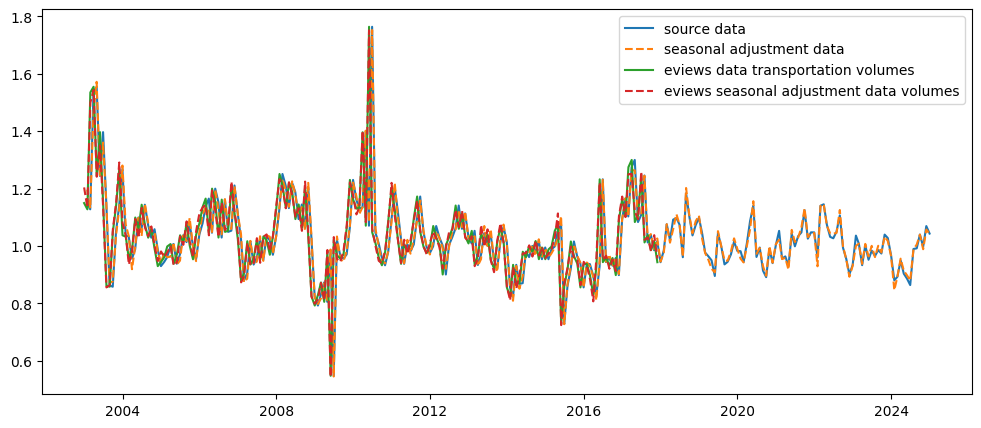

In [96]:
import matplotlib.pyplot as plt

for idx, row in df_2003_2024_with_index.iterrows():
  if idx =='Coal':
    data = row

    res = sm.tsa.x13_arima_analysis(data, freq='M')

    adjusted_series = res.seasadj

    print(idx)
    plt.figure(figsize=(12,5))
    plt.plot(data, label="source data")
    plt.plot(adjusted_series, label="seasonal adjustment data", linestyle="dashed")
    plt.plot(df_eviews['coal' + '_m'], label="eviews data transportation volumes")
    plt.plot(df_eviews['coal' + '_m_sa'], label="eviews seasonal adjustment data volumes", linestyle="dashed")
    plt.legend()
    plt.show()